## Convert .bin drawing to .npy drawing

### Import

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [10]:
print(np.empty([0,5]))

[]


### Load data

In [15]:
# Get random 1000 drawings from each object
def load_drawings(root, train_test_ratio = 0.2, max_drawings = 1000):
  all_files = glob.glob(os.path.join(root, '*.npy'))
  
  # Initialize data var
  # Image is 28x28 => need an 784 input cells
  x = np.empty([0,784])
  y = np.empty([0])
  object_names = []
  
  for index, file in enumerate(all_files):
    data = np.load(file)
    
    # Get some drawings
    data = data[0:max_drawings, :]
    labels = np.full(data.shape[0], index)
    
    # Add image to result
    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)
    
    # Add read file to object
    object_name, ext = os.path.splitext(os.path.basename(file))
    object_names.append(object_name)
    
    # Reset data and labels
    data = None
    labels = None
    
  # Take random data set
  permutation = np.random.permutation(y.shape[0])
  x = x[permutation, :]
  y = y[permutation]
  
  # Split data to training/testing
  size = int(x.shape[0]/100*(train_test_ratio*100))
  x_train = x[0:size, :]
  y_train = y[0:size]
  
  x_test = x[size: x.shape[0], :]
  y_test = y[size: y.shape[0]]
  return x_train, y_train, x_test, y_test, object_names

In [16]:
x_train, y_train, x_test, y_test, object_names = load_drawings('npy_data')
num_objects = len(object_names)
img_res = 28

#### Random data + Plot from bitmap

circle


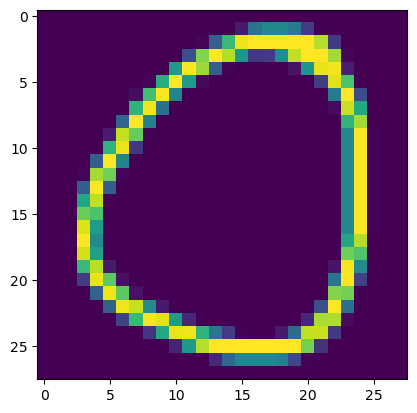

In [18]:
from random import randint
%matplotlib inline
index = randint(0, len(x_train))
plt.imshow(x_train[index].reshape(img_res, img_res))
print(object_names[int(y_train[index].item())])

In [38]:
import pandas as pd

temp_x_train = [bit_map.reshape(28,28) for bit_map in x_train]
temp_y_train = [object_names[int(index)] for index in y_train]
data = {
  'Word': temp_y_train,
  'Image': temp_x_train,
}

df = pd.DataFrame(data)
pd.set_option('display.width', None)  # Display full width

In [39]:
df.sample(10)

,Word,Image
179,square,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
458,square,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
495,square,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
310,square,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
136,square,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
450,square,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
471,square,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
30,triangle,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
528,triangle,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,triangle,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
